# Mineria De Datos

In [79]:
#Librerias necesarias
import pandas as pd
import mglearn
import sklearn
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA

#Librerias de Clasificadores
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.metrics import classification_report
from string import ascii_uppercase
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [80]:
#Solicitar archivo
print("Menu de Archivos: ")
print("1.Slice409")
print("2.cre300")


respuesta = int(input("Ingrese una opcion: "))
archivo_datos = ""

#Extraer datos del archivo csv

if respuesta==1:
    archivo_datos = 'Slice409.csv'
elif respuesta==2:
    archivo_datos = 'cre300.csv'
else:
    print("El archivo no existe")
    
try:
    with open(archivo_datos, "r") as archivo:
        caracteristicas = []
        
        n_elementos = int(archivo.readline())
        n_atributos = int(archivo.readline())
        n_clases = int(archivo.readline())
       
        for i in range(0, n_atributos):
            caracteristicas.append("clase: " + str(i+1))
        
        caracteristicas.append("clase")
        
        datos = pd.read_csv(archivo, delimiter=',', header=None)
        datos.columns = caracteristicas
    
except FileNotFoundError:
    print( "ERROR: No se pudo cargar el archivo ");
finally:
    archivo.close();
conjuntoDatos = datos; 

#Estandarizar conjunto de datos con fomra gaussiana
x = conjuntoDatos
y = caracteristicas
conjuntoDatos = preprocessing.scale(x)

clases = x["clase"]

#Aplicar PCA conjunto de datos
numeroComponentes = int(input("numero de componentes: "))
pca = PCA(n_components=numeroComponentes)
pca.fit(conjuntoDatos)
transformada = pca.transform(conjuntoDatos)

#Separando datos
x_train, x_test, y_train, y_test = train_test_split(transformada, 
                                                    clases, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

#Creando clasificador knn
knn = KNeighborsClassifier(n_neighbors= int(input("numero de vecinos mas cercanos para KNN: ")))
knn.fit(x_train,y_train)

#Creando Red Neuronal
n_iteraciones = int(input("Numero de iteraciones: "))
n_capas = int(input("Numero de capas ocultas: "))
n_nodos = int(input("Numero de nodos por capa: "))
moment = float(input("Momentum [0-1]: "))
red=MLPClassifier(max_iter = n_iteraciones, 
                  hidden_layer_sizes=(n_capas, n_nodos),
                  momentum = moment)
red.fit(x_train, y_train)

#Creando Naive Bayes
NaiveBayes = GaussianNB()
NaiveBayes.fit(x_train, y_train)

#Crear Ensamble de modelos
estimator = [] 
estimator.append(('KNN',  
                  knn)) 
estimator.append(('red', red)) 
estimator.append(('NaiveBayes', NaiveBayes)) 
  
#Voting Classifier with hard voting 
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
#Validación cruzada
kf = KFold(n_splits=int(input("Numero de K-fold: ")), shuffle=True, random_state=2)
for entrenamiento_indice, prueba_indice in kf.split(transformada):
    #print("Entrenamiento: ", entrenamiento_indice, "Prueba: ", prueba_indice)
    X_entrenamiento, X_prueba = transformada[entrenamiento_indice], transformada[prueba_indice]
    y_entrenamiento, y_prueba = clases[entrenamiento_indice], clases[prueba_indice]
    vot_hard.fit(X_entrenamiento, y_entrenamiento)
    y_pred = vot_hard.predict(X_prueba)
    
#Calcular precisión del ensamble
score = accuracy_score(y_prueba, y_pred)

Menu de Archivos: 
1.Slice409
2.cre300
Ingrese una opcion: 1
numero de componentes: 2
numero de vecinos mas cercanos para KNN: 7
Numero de iteraciones: 100000
Numero de capas ocultas: 10
Numero de nodos por capa: 20
Momentum [0-1]: .8
Numero de K-fold: 5


# Graficas 2D PCA

	 	 	 Grafica de PCA


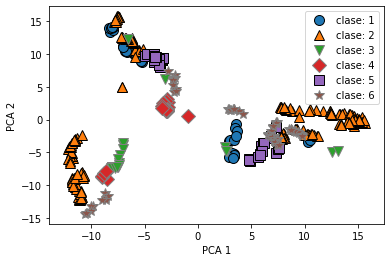

In [81]:
#Graficando en 2d PCA
mglearn.discrete_scatter(transformada[:,0], transformada[:,1], clases)
plt.legend(y, loc="best")
plt.gca()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
print("\t \t \t Grafica de PCA")
plt.show()


# Matriz de Confusión

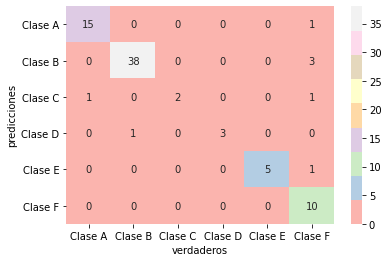

In [82]:
#Graficando matriz de confusion
confm = confusion_matrix(y_prueba, y_pred)
columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(y_pred))]]
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)
grafica = sns.heatmap(df_cm, cmap='Pastel1', annot=True)
plt.ylabel('Valores Verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel="verdaderos", ylabel="predicciones")
plt.show()

# Reporte de Clasificación

In [83]:
#Generar Reporte de Clasificación
print("Reporte de clasificacion")
acc = accuracy_score(y_prueba, y_pred)
print(classification_report(y_prueba, y_pred, target_names=columnas))

Reporte de clasificacion
              precision    recall  f1-score   support

     Clase A       0.94      0.94      0.94        16
     Clase B       0.97      0.93      0.95        41
     Clase C       1.00      0.50      0.67         4
     Clase D       1.00      0.75      0.86         4
     Clase E       1.00      0.83      0.91         6
     Clase F       0.62      1.00      0.77        10

    accuracy                           0.90        81
   macro avg       0.92      0.82      0.85        81
weighted avg       0.93      0.90      0.90        81



# Graficas de Regiones de decisión

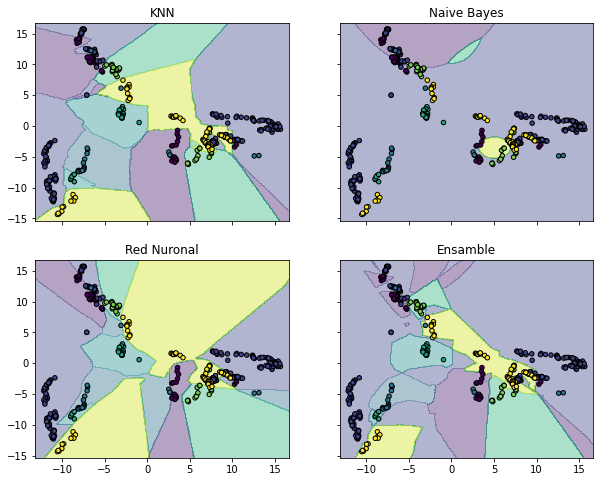

In [84]:
from itertools import product

# Graficando Regiones de decisión
x_min, x_max = transformada[:, 0].min() - 1, transformada[:, 0].max() + 1
y_min, y_max = transformada[:, 1].min() - 1, transformada[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
for idx, clf, tt in zip(product([0, 1], repeat=2),
                        [knn, NaiveBayes, red, vot_hard],
                        ['KNN', 'Naive Bayes',
                         'Red Nuronal', 'Ensamble']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(transformada[:, 0], transformada[:, 1], c=clases,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()